In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import pathlib
import os
import shutil
import random
import json
import matplotlib.pyplot as plt


# ClassifierBase: Abstract Base Class for the Classifier
class ClassifierBase:
    def __init__(self, dataset_url: str, subset_classes: int, input_shape: tuple, batch_size: int):
        self.dataset_url = dataset_url
        self.subset_classes = subset_classes
        self.input_shape = input_shape
        self.batch_size = batch_size

    def prepare_dataset(self):
        raise NotImplementedError("prepare_dataset() must be implemented by subclasses.")

    def create_generators(self):
        raise NotImplementedError("create_generators() must be implemented by subclasses.")


# DataHandler: Handles Dataset Preparation
class DataHandler:
    def __init__(self, data_dir: pathlib.Path, subset_data_dir: pathlib.Path):
        self.data_dir = data_dir
        self.subset_data_dir = subset_data_dir

    def prepare_dataset(self, chosen_classes: list, images_per_class: int):
        if self.subset_data_dir.exists():
            shutil.rmtree(self.subset_data_dir)
        os.makedirs(self.subset_data_dir, exist_ok=True)

        for cls in chosen_classes:
            original_class_dir = self.data_dir / cls
            subset_class_dir = self.subset_data_dir / cls
            os.makedirs(subset_class_dir, exist_ok=True)

            images = os.listdir(original_class_dir)
            selected_images = random.sample(images, min(images_per_class, len(images)))

            for img in selected_images:
                shutil.copy(original_class_dir / img, subset_class_dir)
        print("Dataset prepared successfully.")

    def load_data(self):
        return sorted(os.listdir(self.data_dir))


# FoodClassifierWithCalories: Main Classifier Implementation
class FoodClassifierWithCalories(ClassifierBase):
    def __init__(self, dataset_url: str, subset_classes: int, input_shape: tuple, batch_size: int, calorie_mapping: dict):
        super().__init__(dataset_url, subset_classes, input_shape, batch_size)
        self.calorie_mapping = calorie_mapping
        self.data_dir = pathlib.Path(tf.keras.utils.get_file("food-101", origin=dataset_url, untar=True)) / "images"
        self.subset_data_dir = pathlib.Path("subset_food101")
        self.chosen_classes = []
        self.model = None
        self.train_generator = None
        self.val_generator = None

    def prepare_dataset(self, images_per_class: int):
        handler = DataHandler(self.data_dir, self.subset_data_dir)
        self.chosen_classes = handler.load_data()[:self.subset_classes]
        handler.prepare_dataset(self.chosen_classes, images_per_class)

    def create_generators(self):
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2
        )

        self.train_generator = train_datagen.flow_from_directory(
            self.subset_data_dir,
            target_size=self.input_shape[:2],
            batch_size=self.batch_size,
            class_mode="categorical",
            subset="training",
            shuffle=True
        )

        self.val_generator = train_datagen.flow_from_directory(
            self.subset_data_dir,
            target_size=self.input_shape[:2],
            batch_size=self.batch_size,
            class_mode="categorical",
            subset="validation"
        )

    def compute_class_weights(self):
        classes = self.train_generator.classes
        return class_weight.compute_class_weight(
            class_weight="balanced",
            classes=np.unique(classes),
            y=classes
        )

    def build_model(self):
        base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=self.input_shape)
        base_model.trainable = True

        inputs = layers.Input(shape=self.input_shape)
        x = base_model(inputs)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1500, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(1000, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.subset_classes, activation="softmax")(x)

        self.model = Model(inputs, outputs)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

    def save_class_indices_with_calories(self, filepath: str):
        if not self.train_generator:
            raise ValueError("Train generator not initialized. Create generators before saving class indices.")

        class_mapping_with_calories = {
            class_name: {
                "index": index,
                "calories": self.calorie_mapping.get(class_name, "Unknown")
            }
            for class_name, index in self.train_generator.class_indices.items()
        }

        with open(filepath, 'w') as f:
            json.dump(class_mapping_with_calories, f, indent=4)
        print(f"Class indices with calorie mapping saved to {filepath}")


# ModelTrainer: Handles Model Training and Evaluation
class ModelTrainer:
    def __init__(self, model: tf.keras.Model, train_generator, val_generator):
        self.model = model
        self.train_generator = train_generator
        self.val_generator = val_generator

    def train(self, epochs: int, callbacks: list):
        class_weights = dict(enumerate(class_weight.compute_class_weight(
            class_weight="balanced",
            classes=np.unique(self.train_generator.classes),
            y=self.train_generator.classes
        )))

        history = self.model.fit(
            self.train_generator,
            validation_data=self.val_generator,
            epochs=epochs,
            class_weight=class_weights,
            callbacks=callbacks
        )
        return history

    def evaluate_model(self):
        loss, accuracy = self.model.evaluate(self.val_generator)
        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")

    def save_model(self, filepath: str):
        self.model.save(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath: str):
        self.model = tf.keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")


# Visualizer: Handles Predictions and Visualization
class Visualizer:
    def __init__(self, model: tf.keras.Model, class_indices: dict, calorie_mapping: dict):
        self.model = model
        self.class_indices = class_indices
        self.calorie_mapping = calorie_mapping

    def predict_and_visualize_with_calories(self, generator, num_samples: int = 10):
        test_images, test_labels = next(iter(generator))
        predictions = self.model.predict(test_images)
        predicted_classes = np.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            plt.subplot(2, 5, i + 1)
            plt.imshow(test_images[i])

            true_class = list(self.class_indices.keys())[list(self.class_indices.values()).index(np.argmax(test_labels[i]))]
            pred_class = list(self.class_indices.keys())[list(self.class_indices.values()).index(predicted_classes[i])]

            predicted_calories = self.calorie_mapping.get(pred_class, "Calories Not Found")

            color = "green" if pred_class == true_class else "red"
            plt.title(f"True: {true_class}\nPred: {pred_class}\nCalories: {predicted_calories}", color=color)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

In [18]:
# Implementation Steps
dataset_url = "https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
input_shape = (224, 224, 3)
subset_classes = 80
batch_size = 64

In [19]:
calorie_mapping = {
    "apple_pie": 296,
    "baby_back_ribs": 484,
    "baklava": 334,
    "beef_carpaccio": 120,
    "beef_tartare": 230,
    "beet_salad": 150,
    "beignets": 389,
    "bibimbap": 490,
    "bread_pudding": 312,
    "breakfast_burrito": 290,
    "bruschetta": 170,
    "caesar_salad": 190,
    "cannoli": 216,
    "caprese_salad": 160,
    "carrot_cake": 330,
    "ceviche": 120,
    "cheese_plate": 400,
    "cheesecake": 257,
    "chicken_curry": 270,
    "chicken_quesadilla": 310,
    "chicken_wings": 430,
    "chocolate_cake": 235,
    "chocolate_mousse": 250,
    "churros": 116,
    "clam_chowder": 180,
    "club_sandwich": 275,
    "crab_cakes": 190,
    "creme_brulee": 300,
    "croque_madame": 560,
    "cup_cakes": 177,
    "deviled_eggs": 64,
    "donuts": 195,
    "dumplings": 230,
    "edamame": 120,
    "eggs_benedict": 300,
    "escargots": 200,
    "falafel": 333,
    "filet_mignon": 679,
    "fish_and_chips": 500,
    "foie_gras": 450,
    "french_fries": 312,
    "french_onion_soup": 120,
    "french_toast": 210,
    "fried_calamari": 290,
    "fried_rice": 250,
    "frozen_yogurt": 112,
    "garlic_bread": 206,
    "gnocchi": 200,
    "greek_salad": 160,
    "grilled_cheese_sandwich": 400,
    "grilled_salmon": 360,
    "guacamole": 230,
    "gyoza": 200,
    "hamburger": 354,
    "hot_and_sour_soup": 100,
    "hot_dog": 290,
    "huevos_rancheros": 220,
    "hummus": 166,
    "ice_cream": 137,
    "lasagna": 290,
    "lobster_bisque": 230,
    "lobster_roll_sandwich": 450,
    "macaroni_and_cheese": 300,
    "macarons": 100,
    "miso_soup": 40,
    "mussels": 150,
    "nachos": 346,
    "omelette": 200,
    "onion_rings": 400,
    "oysters": 95,
    "pad_thai": 350,
    "paella": 370,
    "pancakes": 175,
    "panna_cotta": 280,
    "peking_duck": 375,
    "pho": 400,
    "pizza": 266,
    "pork_chop": 250,
    "poutine": 650,
    # "prime_rib": 670,
    # "pulled_pork_sandwich": 310,
    # "ramen": 436,
    # "ravioli": 320,
    # "red_velvet_cake": 293,
    # "risotto": 360,
    # "samosa": 250,
    # "sashimi": 180,
    # "scallops": 130,
    # "seaweed_salad": 50,
    # "shrimp_and_grits": 290,
    # "spaghetti_bolognese": 310,
    # "spaghetti_carbonara": 370,
    # "spring_rolls": 200,
    # "steak": 679,
    # "strawberry_shortcake": 300,
    # "sushi": 200,
    # "tacos": 225,
    # "takoyaki": 125,
    # "tiramisu": 240,
    # "tuna_tartare": 130,
    # "waffles": 210,
}

In [22]:
# Initialize and execute steps
classifier = FoodClassifierWithCalories(dataset_url, subset_classes, input_shape, batch_size, calorie_mapping)
classifier.prepare_dataset(images_per_class=700)
classifier.create_generators()
classifier.build_model()

Dataset prepared successfully.
Found 44800 images belonging to 80 classes.
Found 11200 images belonging to 80 classes.


In [23]:
trainer = ModelTrainer(classifier.model, classifier.train_generator, classifier.val_generator)
trainer.train(epochs=15, callbacks=[
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
    ModelCheckpoint("best_model.keras", save_best_only=True, verbose=1)
])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.2096 - loss: 20.5114
Epoch 1: val_loss improved from inf to 5.15720, saving model to best_model.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 796s 947ms/step - accuracy: 0.2098 - loss: 20.5009 - val_accuracy: 0.5307 - val_loss: 5.1572 - learning_rate: 1.0000e-04
Epoch 2/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.6673 - loss: 3.6778
Epoch 2: val_loss improved from 5.15720 to 1.93830, saving model to best_model.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 654s 927ms/step - accuracy: 0.6674 - loss: 3.6768 - val_accuracy: 0.7404 - val_loss: 1.9383 - learning_rate: 1.0000e-04
Epoch 3/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.7493 - loss: 1.7608
Epoch 3: val_loss improved from 1.93830 to 1.43402, saving model to best_model.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 652s 924ms/step - accuracy: 0.7493 - loss: 1.7606 - val_accuracy: 0.7578 - val_loss: 1.4340 - learning_rate: 1.0000e-04
Epoch 4/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 742m

In [25]:
classifier.save_class_indices_with_calories("class_indices_with_calories.json")

Class indices with calorie mapping saved to class_indices_with_calories.json


In [26]:
from google.colab import files

# Download the file to local machine
files.download("class_indices_with_calories.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


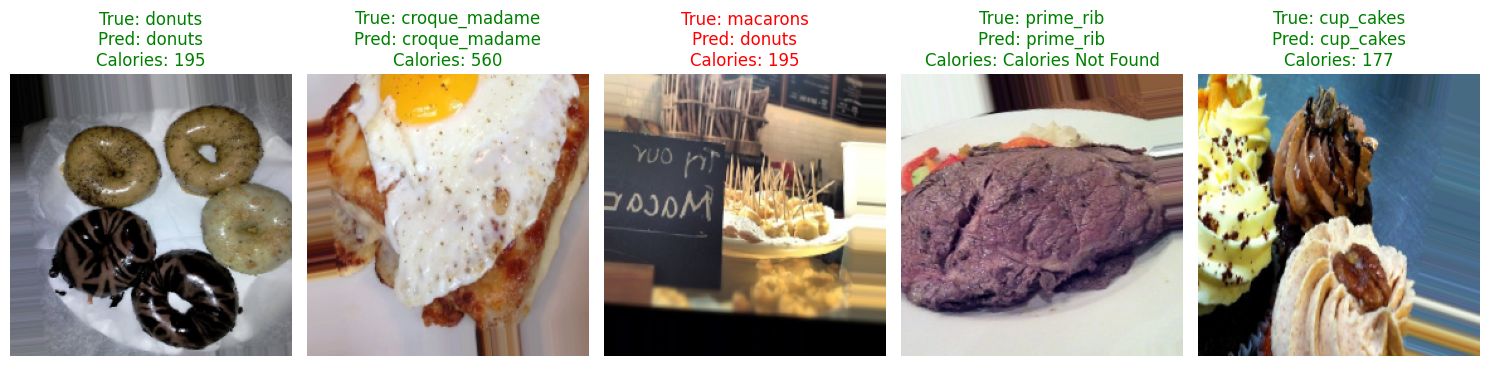

In [31]:
visualizer = Visualizer(classifier.model, classifier.train_generator.class_indices, calorie_mapping)
visualizer.predict_and_visualize_with_calories(generator=classifier.val_generator, num_samples=5)

In [28]:
# Save the trained model
trainer.save_model("best_model.keras")

Model saved to best_model.keras


In [29]:
from google.colab import files
files.download("best_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>